## Librairies used 

In [1]:
import requests
import json
import gzip
import shutil
import time
import os
from io import BytesIO
import pandas as pd
import datetime as dt
import random

## Utilities function for data preparation 

In [2]:
def extract_game_state_data(game_event,value=0) :
    '''We process the relevant status updates and add them to dictionaries to output.
    The game event and the list of participants on both teams must be provided.
    By default, without any parameter, the function will treat this event as an endgame
    event depending on the game status. Please specify either 10 or 15 on 'value' for those
    two events.'''
    dict_output = {}
    gameOver = (game_event.get('eventType') == 'game_state_end')
    value = 'End' if gameOver else value 

    player_data = [i for i in game_event.get('participants') if (0 < i.get('participantID') < 11)]
    player_data = sorted(player_data, key = lambda x: x['participantID'])

    if (value == 10 or value == 15) or gameOver:

        #Initializing variables:
        gold_top_blue = player_data[0]['totalGold']
        gold_top_red = player_data[5]['totalGold']
        gold_diff_top = gold_top_blue - gold_top_red
        
        gold_jg_blue = player_data[1]['totalGold']
        gold_jg_red = player_data[6]['totalGold']
        gold_diff_jg = gold_jg_blue - gold_jg_red
        
        gold_mid_blue = player_data[2]['totalGold']
        gold_mid_red = player_data[7]['totalGold']
        gold_diff_mid = gold_mid_blue - gold_mid_red
        
        gold_ad_blue = player_data[3]['totalGold']
        gold_ad_red = player_data[8]['totalGold']
        gold_diff_ad = gold_ad_blue - gold_ad_red
        
        gold_sup_blue = player_data[4]['totalGold']
        gold_sup_red = player_data[9]['totalGold']
        gold_diff_sup = gold_sup_blue - gold_sup_red
        
        xp_diff_top = player_data[0]['XP'] - player_data[5]['XP']
        xp_diff_jg = player_data[1]['XP'] - player_data[6]['XP']
        xp_diff_mid = player_data[2]['XP'] - player_data[7]['XP']
        xp_diff_ad = player_data[3]['XP'] - player_data[8]['XP']
        xp_diff_sup = player_data[4]['XP'] - player_data[9]['XP']
        dict_output.update({
            f'GoldTopBlue{value}': gold_top_blue,
            f'GoldJgBlue{value}': gold_jg_blue,
            f'GoldMidBlue{value}': gold_mid_blue,
            f'GoldADBlue{value}': gold_ad_blue,
            f'GoldSupBlue{value}': gold_sup_blue,
            f'GoldTopRed{value}': gold_top_red,
            f'GoldJgRed{value}': gold_jg_red,
            f'GoldMidRed{value}': gold_mid_red,
            f'GoldADRed{value}': gold_ad_red,
            f'GoldSupRed{value}': gold_sup_red,
            f'GoldDiff{value}Top': gold_diff_top,
            f'GoldDiff{value}Jg': gold_diff_jg,
            f'GoldDiff{value}Mid': gold_diff_mid,
            f'GoldDiff{value}AD': gold_diff_ad,
            f'GoldDiff{value}Bot': gold_diff_sup,
            f'XPDiff{value}Top': xp_diff_top,
            f'XPDiff{value}Jg': xp_diff_jg,
            f'XPDiff{value}Mid': xp_diff_mid,
            f'XPDiff{value}AD': xp_diff_ad,
            f'XPDiff{value}Bot': xp_diff_sup,
        })
        
        blue_kills, red_kills = game_event['blue']['championsKills'], game_event['red']['championsKills']
        blue_assists, red_assists = game_event['blue']['assists'], game_event['red']['assists']
        blue_deaths, red_deaths = game_event['blue']['deaths'], game_event['red']['deaths']
        blue_gold, red_gold = game_event['blue']['totalGold'], game_event['red']['totalGold']
        blue_tower_kills, red_tower_kills = game_event['blue']['towerKills'], game_event['red']['towerKills']
        blue_dragon_kills, red_dragon_kills = game_event['blue']['dragonKills'], game_event['red']['dragonKills']
        dict_output.update({
            f'BlueKills{value}': blue_kills,
            f'BlueAssists{value}': blue_assists,
            f'BlueDeaths{value}': blue_deaths,
            f'BlueTotalGold{value}': blue_gold,
            f'BlueDragonKills{value}': blue_dragon_kills,
            f'BlueTowerKills{value}': blue_tower_kills,
            f'RedKills{value}': red_kills,
            f'RedAssists{value}': red_assists,
            f'RedDeaths{value}': red_deaths,
            f'RedTotalGold{value}': red_gold,
            f'RedDragonKills{value}': red_dragon_kills,
            f'RedTowerKills{value}': red_tower_kills
        })
        
        if value != 10:
            blue_inhib_kills, red_inhib_kills = game_event['blue']['inhibKills'], game_event['red']['inhibKills']
            dict_output.update({
                f'BlueInhibKills{value}': blue_inhib_kills,
                f'RedInhibKills{value}': red_inhib_kills
            })
            
        if gameOver:
            blue_baron_kills, red_baron_kills = game_event['blue']['baronKills'], game_event['red']['baronKills']
            dict_output.update({
                f'BlueBaronKills{value}': blue_baron_kills,
                f'RedBaronKills{value}': red_baron_kills
            })
            
            blue_vision_score_top = player_data[0]['VISION_SCORE']
            blue_vision_score_jg = player_data[1]['VISION_SCORE']
            blue_vision_score_mid = player_data[2]['VISION_SCORE']
            blue_vision_score_ad = player_data[3]['VISION_SCORE']
            blue_vision_score_sup = player_data[4]['VISION_SCORE']
            red_vision_score_top = player_data[5]['VISION_SCORE']
            red_vision_score_jg = player_data[6]['VISION_SCORE']
            red_vision_score_mid = player_data[7]['VISION_SCORE']
            red_vision_score_ad = player_data[8]['VISION_SCORE']
            red_vision_score_sup = player_data[9]['VISION_SCORE']

            dict_output.update({
                'VisionScoreTopBlue': blue_vision_score_top,
                'VisionScoreJgBlue': blue_vision_score_jg,
                'VisionScoreMidBlue': blue_vision_score_mid,
                'VisionScoreADBlue': blue_vision_score_ad,
                'VisionScoreSupBlue': blue_vision_score_sup,
                'VisionScoreTopRed': red_vision_score_top,
                'VisionScoreJgRed': red_vision_score_jg,
                'VisionScoreMidRed': red_vision_score_mid,
                'VisionScoreADRed': red_vision_score_ad,
                'VisionScoreSupRed': red_vision_score_sup
            })

            blue_damage_dealt_top = player_data[0]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']
            blue_damage_dealt_jg = player_data[1]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']
            blue_damage_dealt_mid = player_data[2]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']
            blue_damage_dealt_ad = player_data[3]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']
            blue_damage_dealt_sup = player_data[4]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']
            red_damage_dealt_top = player_data[5]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']
            red_damage_dealt_jg = player_data[6]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']
            red_damage_dealt_mid = player_data[7]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']
            red_damage_dealt_ad = player_data[8]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']
            red_damage_dealt_sup = player_data[9]['TOTAL_DAMAGE_DEALT_TO_CHAMPIONS']

            dict_output.update({
                'DamageDealtTopBlue': blue_damage_dealt_top,
                'DamageDealtJgBlue': blue_damage_dealt_jg,
                'DamageDealtMidBlue': blue_damage_dealt_mid,
                'DamageDealtADBlue': blue_damage_dealt_ad,
                'DamageDealtSupBlue': blue_damage_dealt_sup,
                'DamageDealtTopRed': red_damage_dealt_top,
                'DamageDealtJgRed': red_damage_dealt_jg,
                'DamageDealtMidRed': red_damage_dealt_mid,
                'DamageDealtADRed': red_damage_dealt_ad,
                'DamageDealtSupRed': red_damage_dealt_sup
            })
            
            blue_damage_taken_top = player_data[0]['TOTAL_DAMAGE_TAKEN']
            blue_damage_taken_jg = player_data[1]['TOTAL_DAMAGE_TAKEN']
            blue_damage_taken_mid = player_data[2]['TOTAL_DAMAGE_TAKEN']
            blue_damage_taken_ad = player_data[3]['TOTAL_DAMAGE_TAKEN']
            blue_damage_taken_sup = player_data[4]['TOTAL_DAMAGE_TAKEN']
            red_damage_taken_top = player_data[5]['TOTAL_DAMAGE_TAKEN']
            red_damage_taken_jg = player_data[6]['TOTAL_DAMAGE_TAKEN']
            red_damage_taken_mid = player_data[7]['TOTAL_DAMAGE_TAKEN']
            red_damage_taken_ad = player_data[8]['TOTAL_DAMAGE_TAKEN']
            red_damage_taken_sup = player_data[9]['TOTAL_DAMAGE_TAKEN']

            dict_output.update({
                'DamageTakenTopBlue': blue_damage_taken_top,
                'DamageTakenJgBlue': blue_damage_taken_jg,
                'DamageTakenMidBlue': blue_damage_taken_mid,
                'DamageTakenADBlue': blue_damage_taken_ad,
                'DamageTakenSupBlue': blue_damage_taken_sup,
                'DamageTakenTopRed': red_damage_taken_top,
                'DamageTakenJgRed': red_damage_taken_jg,
                'DamageTakenMidRed': red_damage_taken_mid,
                'DamageTakenADRed': red_damage_taken_ad,
                'DamageTakenSupRed': red_damage_taken_sup
            })

            blue_cc_score_top = player_data[0]['TIME_CCING_OTHERS']
            blue_cc_score_jg = player_data[1]['TIME_CCING_OTHERS']
            blue_cc_score_mid = player_data[2]['TIME_CCING_OTHERS']
            blue_cc_score_ad = player_data[3]['TIME_CCING_OTHERS']
            blue_cc_score_sup = player_data[4]['TIME_CCING_OTHERS']
            red_cc_score_top = player_data[5]['TIME_CCING_OTHERS']
            red_cc_score_jg = player_data[6]['TIME_CCING_OTHERS']
            red_cc_score_mid = player_data[7]['TIME_CCING_OTHERS']
            red_cc_score_ad = player_data[8]['TIME_CCING_OTHERS']
            red_cc_score_sup = player_data[9]['TIME_CCING_OTHERS']

            dict_output.update({
                'TotalCCDurationTopBlue': blue_cc_score_top,
                'TotalCCDurationJgBlue': blue_cc_score_jg,
                'TotalCCDurationMidBlue': blue_cc_score_mid,
                'TotalCCDurationADBlue': blue_cc_score_ad,
                'TotalCCDurationSupBlue': blue_cc_score_sup,
                'TotalCCDurationTopRed': red_cc_score_top,
                'TotalCCDurationJgRed': red_cc_score_jg,
                'TotalCCDurationMidRed': red_cc_score_mid,
                'TotalCCDurationADRed': red_cc_score_ad,
                'TotalCCDurationSupRed': red_cc_score_sup
            })            

    return dict_output

In [3]:
def add_event_to_counter(event_counter, player_index, team, team_ids_blue, team_ids_red):
    '''We get an event and assign it to the correct team.
    The code takes under account possible lapses in our data (if we don't have a 'team'
    but have the list of participants).'''
    
    changed_counter = event_counter
    team_result = team
    
    if team_result is None:
        if player_index in team_ids_blue:
            team_result = 'blue'
        elif player_index in team_ids_red:
            team_result = 'red'

    #This is not an ELSE situation. I want to run this after we attempt to fix the issue above.
    if team_result is not None:
        changed_counter[team_result.lower()]+=1

    return (changed_counter, team_result)

In [4]:
def final_data(game_json):
    dict_stats = {}
    game_info_dict = {}
    game_state_10 = {}
    game_state_15 = {}
    game_state_end = {}
    header_stats = None
    wards_placed = [0 for i in range(0,10)]
    control_wards_placed = [0 for i in range(0,10)]
    wards_killed = [0 for i in range(0,10)]
    control_wards_killed = [0 for i in range(0,10)]
    current_event = None
    previous_event = None
    game_duration = 7200 #Put it at two hours for funsies.
    game_winner = None
    dragon_type_queued = [None, None]
    dragon_index = 0
    dragon_soul_taken = False
    dragon_soul = {
        'DragonSoulTimer':None,
        'DragonSoulType':None,
        'DragonSoulTaker':None
    }

    default_dict = {'blue':0,'red':0}
    elder_dragons_taken = {'blue':0,'red':0}
    own_camps_taken = {'blue':0,'red':0}
    enemy_camps_taken = {'blue':0,'red':0}
    rift_herald_count = {'blue':0,'red':0}
    scuttle_count = {'blue':0,'red':0}
    dragon_count = {'blue':0,'red':0}
    dragon_type_count = {'blue':{}, 'red':{}}
    baron_count = {'blue':0,'red':0}
    tower_count = {'blue':0,'red':0}
    tower_log = {
        'OuterTopBlueTimer': None,
        'OuterMidBlueTimer': None,
        'OuterBotBlueTimer': None,
        'InnerTopBlueTimer': None,
        'InnerMidBlueTimer': None,
        'InnerBotBlueTimer': None,
        'BaseTopBlueTimer': None,
        'BaseMidBlueTimer': None,
        'BaseBotBlueTimer': None,
        'Nexus1MidBlueTimer': None,
        'Nexus2MidBlueTimer': None,
        'OuterTopRedTimer': None,
        'OuterMidRedTimer': None,
        'OuterBotRedTimer': None,
        'InnerTopRedTimer': None,
        'InnerMidRedTimer': None,
        'InnerBotRedTimer': None,
        'BaseTopRedTimer': None,
        'BaseMidRedTimer': None,
        'BaseBotRedTimer': None,
        'Nexus1MidRedTimer': None,
        'Nexus2MidRedTimer': None
    } #Time values for each event
    team_side = None

    smaller_camps = ['blueCamp','redCamp','gromp','wolf','krug','raptor']

    #Data integrity check, but also getting relevant data.
    if game_json[-1].get('eventType',None) != 'game_end':
        print("The game's data does not contain the entirety of the game.")
        #TO_DO: plug Tim's game_end timestamp (game duration)
    else:
        game_duration = game_json[-1].get('gameTime')
        game_winner = game_json[-1].get('winningTeam')
        
    for game_event in game_json:
        
        # In case we have our intro header somewhere in there:
        if game_event.get('eventType',None) is None:
            
            try:
                game_date_str = game_event.get('gameDate', None)
                if game_date_str:
                    game_date_str = game_date_str.replace('Z', '+00:00')  # Replace 'Z' with '+00:00'
                    game_date = dt.datetime.fromisoformat(game_date_str)
            except ValueError as e:
                print(f"Error parsing date: {e}")

            esports_platform = game_event.get('esportsPlatformId',None)
            game_patch = game_event.get('gameVersion',None)
            header_stats = {
                'gameDate': game_date,
                'esportsPlatformId': esports_platform,
                'gameVersion': game_patch
            }

        else:
            current_event = game_event.get('eventType',None)

        # Important bit: we get our game info.
        if game_event.get('eventType') == 'game_info':
            blue_participant_id = []
            red_participant_id = []
            blue_summoner_name = []
            red_summoner_name = []
            blue_champion = []
            red_champion = []
            
            blue_data = game_event.get('blue')
            for player in blue_data:
                blue_participant_id.append(player.get('participantID'))
                blue_summoner_name.append(player.get('summonerName'))
                blue_champion.append(player.get('championName'))

            red_data = game_event.get('red')
            for player in red_data:
                red_participant_id.append(player.get('participantID'))
                red_summoner_name.append(player.get('summonerName'))
                red_champion.append(player.get('championName'))

        if game_event.get('eventType') == 'queued_dragon_info':
            dragon_index = dragon_index + 1
            if dragon_type_queued[0] is None:
                dragon_type_queued[0] = game_event.get('nextDragonName')
            else:
                dragon_type_queued[1] = game_event.get('nextDragonName')

        if game_event.get('eventType') == 'epic_monster_kill':
            #So, there are A LOT of epic monsters killed.
            #The events have the "killer" in common.
            killer = game_event.get('killer')
            killer_team = game_event.get('team')
            
            #Step 1: counterjungle tally
            if game_event.get('inEnemyJungle'):
                #Temporary workaround given data mistakes were made
                enemy_camps_taken = add_event_to_counter(enemy_camps_taken, killer, killer_team,
                                                        blue_participant_id, red_participant_id)[0]
            #If no counterjungling is afoot, take this number instead:
            elif game_event.get('monsterType') in smaller_camps:
                own_camps_taken = add_event_to_counter(own_camps_taken, killer, killer_team,
                                                        blue_participant_id, red_participant_id)[0]

            #Step 2: Scuttles, Heralds, Barons, and Dragons
            if game_event.get('monsterType') == 'scuttleCrab':
                scuttle_count = add_event_to_counter(scuttle_count, killer, killer_team,
                                                        blue_participant_id, red_participant_id)[0]

            if game_event.get('monsterType') == 'riftHerald':
                rift_herald_count = add_event_to_counter(rift_herald_count, killer, killer_team,
                                                        blue_participant_id, red_participant_id)[0]

            if game_event.get('monsterType') == 'baron':
                baron_count = add_event_to_counter(baron_count, killer, killer_team,
                                                        blue_participant_id, red_participant_id)[0]

            if game_event.get('monsterType') == 'dragon':
                dragon_count, team_side = add_event_to_counter(dragon_count, killer, killer_team,
                                                        blue_participant_id, red_participant_id)

                if team_side is not None:
                    if not dragon_soul_taken:
                        nb_dragons = dragon_count[team_side]
                        if nb_dragons == 4:
                            dragon_soul_taken = True
                            dragon_soul = {
                                'DragonSoulTimer':game_event.get('gameTime'),
                                'DragonSoulType':dragon_type_queued[0],
                                'DragonSoulTeam':team_side
                            }
                    else:
                        elder_dragons_taken = add_event_to_counter(elder_dragons_taken, killer, killer_team,
                                                        blue_participant_id, red_participant_id)[0]
                            

                    
                if dragon_type_queued[1] is not None:
                    dragon_type_queued[0] = dragon_type_queued[1]
                    dragon_type_queued[1] = None

        if game_event.get('eventType') == 'building_destroyed':
            try:
                team_side = game_event.get('team',None)
                building_type = game_event.get('buildingType')
                
                if building_type == 'turret' and team_side is not None:
                    building_lane = game_event.get('lane').title()
                    building_tier = game_event.get('turretTier').title()
                    
                    if building_tier == 'Nexus':
                        if tower_log.get(f'{building_tier}1{building_lane}{team_side.title()}Timer',None) is not None:
                            building_tier = 'Nexus2'
                        else:
                            building_tier = 'Nexus1'
                            
                    tower_log.update({f'{building_tier}{building_lane}{team_side.title()}Timer':
                                    game_event.get('gameTime')})
                    tower_count = add_event_to_counter(tower_count, None, team_side,
                                                        None, None)[0]
            except:
                print('Did a building self-destruct by any chance? Something has gone awry here.')

        if game_event.get('eventType') == 'game_state_10mn':
            game_state_10 = extract_game_state_data(game_event,10)

        if game_event.get('eventType') == 'game_state_15mn':
            game_state_15 = extract_game_state_data(game_event,15)
        
        if game_event.get('eventType') == 'game_state_end':
            game_state_end = extract_game_state_data(game_event)
            
        previous_event = current_event
        
            
    #This will be our first entry in the dictionaries.
    if header_stats is not None:
        dict_stats.update(header_stats)

    dict_stats.update({
        'NbCampsSecuredBlue': own_camps_taken['blue'],
        'NbCampsSecuredRed': own_camps_taken['red'],
        'NbCampsStolenBlue': enemy_camps_taken['blue'],
        'NbCampsStolenRed': enemy_camps_taken['red'],
        'NbScuttlesBlue': scuttle_count['blue'],
        'NbScuttlesRed': scuttle_count['red'],
        'NbRiftHeraldsBlue': rift_herald_count['blue'],
        'NbRiftHeraldsRed': rift_herald_count['red'],
        'NbDragonsBlue': dragon_count['blue']-elder_dragons_taken['blue'], #Denotes only regular dragons
        'NbDragonsRed': dragon_count['red']-elder_dragons_taken['red'],
        'NbBaronsBlue': baron_count['blue'],
        'NbBaronsRed': baron_count['red'],
        'NbEldersBlue': elder_dragons_taken['blue'],
        'NbEldersRed': elder_dragons_taken['red'],
        'NbTowersBlue': tower_count['red'],
        'NbTowersRed': tower_count['blue']
    })

    dict_stats.update(tower_log)
    dict_stats.update(dragon_soul)
    dict_stats.update(game_state_10)
    dict_stats.update(game_state_15)
    dict_stats.update(game_state_end)
    dict_stats.update({'winner': game_winner})

    return dict_stats

In [105]:
final_data

<function __main__.final_data(game_json)>

In [112]:
from tqdm import tqdm

dossier_games = 'games'
dossier_esports = 'esports-data'

with open("./esports-data/mapping_data.json", 'r') as mapping_file:
    mappings_data_list = json.load(mapping_file)

mappings_data = {item['platformGameId']: item for item in mappings_data_list}

# List only files with the `.json` extension without building intermediary lists
games = [f for f in os.listdir(dossier_games) if os.path.isfile(os.path.join(dossier_games, f)) and f.endswith('.json')]
list_game=[]

for game in tqdm(games):
    
    try:
        chemin_complet = os.path.join(dossier_games, game)
        with open(chemin_complet, 'r') as path_to_json_game:
            game_json = json.load(path_to_json_game)

        dict_game=final_data(game_json)
        list_game.append(dict_game)
    except KeyError :
        print(game)





  1%|          | 86/7391 [00:00<00:17, 419.43it/s]

ESPORTSTMNT01_3295302.json


  8%|▊         | 604/7391 [00:01<00:13, 515.29it/s]

ESPORTSTMNT01_3324332.json


 10%|▉         | 708/7391 [00:01<00:13, 491.88it/s]

ESPORTSTMNT01_3328669.json


 13%|█▎        | 956/7391 [00:02<00:13, 468.74it/s]

ESPORTSTMNT01_3339121.json
ESPORTSTMNT01_3342236.json


 21%|██        | 1519/7391 [00:03<00:11, 494.35it/s]

ESPORTSTMNT01_3391375.json
ESPORTSTMNT01_3395123.json


 24%|██▍       | 1767/7391 [00:03<00:11, 480.18it/s]

ESPORTSTMNT01_3408461.json


 26%|██▋       | 1958/7391 [00:04<00:13, 390.51it/s]

ESPORTSTMNT01_3416295.json
ESPORTSTMNT01_3416359.json
ESPORTSTMNT01_3417199.json
ESPORTSTMNT01_3417254.json
ESPORTSTMNT01_3417259.json
ESPORTSTMNT01_3417260.json
ESPORTSTMNT01_3418180.json
ESPORTSTMNT01_3418246.json


 30%|██▉       | 2210/7391 [00:04<00:12, 421.68it/s]

ESPORTSTMNT02_3152955.json
ESPORTSTMNT02_3155007.json
ESPORTSTMNT02_3159449.json


 38%|███▊      | 2822/7391 [00:08<00:50, 90.03it/s] 

The game's data does not contain the entirety of the game.


 46%|████▌     | 3383/7391 [00:15<00:45, 89.02it/s]

ESPORTSTMNT03_3087307.json


 48%|████▊     | 3561/7391 [00:17<00:41, 92.57it/s]

ESPORTSTMNT03_3094177.json


 50%|████▉     | 3671/7391 [00:18<00:40, 91.44it/s]

ESPORTSTMNT03_3099838.json


 51%|█████     | 3751/7391 [00:19<00:38, 94.64it/s]

ESPORTSTMNT03_3103008.json
ESPORTSTMNT03_3103197.json


 54%|█████▍    | 3973/7391 [00:21<00:35, 95.66it/s]

ESPORTSTMNT03_3124126.json


 56%|█████▌    | 4103/7391 [00:23<00:34, 94.06it/s]

ESPORTSTMNT03_3128976.json


 59%|█████▉    | 4388/7391 [00:26<00:31, 94.55it/s] 

ESPORTSTMNT03_3167487.json


 68%|██████▊   | 5027/7391 [00:32<00:24, 98.30it/s] 

ESPORTSTMNT03_3198743.json


 70%|██████▉   | 5146/7391 [00:34<00:21, 104.12it/s]

ESPORTSTMNT04_2663989.json


 72%|███████▏  | 5334/7391 [00:35<00:19, 105.88it/s]

ESPORTSTMNT04_2670519.json


 78%|███████▊  | 5742/7391 [00:40<00:17, 93.15it/s] 

ESPORTSTMNT04_2689609.json


 85%|████████▌ | 6313/7391 [00:46<00:12, 89.51it/s] 

ESPORTSTMNT06_2767073.json


 87%|████████▋ | 6446/7391 [00:47<00:09, 103.59it/s]

ESPORTSTMNT06_2773399.json


 88%|████████▊ | 6511/7391 [00:48<00:08, 102.61it/s]

ESPORTSTMNT06_2774361.json
ESPORTSTMNT06_2774402.json


 90%|████████▉ | 6621/7391 [00:49<00:07, 97.62it/s] 

ESPORTSTMNT06_2776003.json


 92%|█████████▏| 6835/7391 [00:51<00:05, 94.27it/s] 

ESPORTSTMNT06_2819332.json
ESPORTSTMNT06_2819365.json


 94%|█████████▎| 6926/7391 [00:52<00:04, 96.68it/s]

ESPORTSTMNT06_2821295.json


 95%|█████████▍| 6986/7391 [00:53<00:04, 96.64it/s]

ESPORTSTMNT06_2823222.json


 95%|█████████▍| 7017/7391 [00:53<00:03, 94.68it/s]

ESPORTSTMNT06_2823458.json


 96%|█████████▌| 7067/7391 [00:54<00:03, 84.43it/s]

LPL_A_331179.json


 98%|█████████▊| 7234/7391 [00:56<00:01, 128.88it/s]


UnboundLocalError: local variable 'blue_participant_id' referenced before assignment

In [113]:
game_dataFrame=pd.DataFrame(list_game)

In [114]:
game_dataFrame=game_dataFrame.dropna(subset='winner')

In [115]:
game_dataFrame.winner.isna().sum()

0

In [117]:
game_dataFrame.to_csv('games_info_dataframe.csv', index=False)

In [116]:
game_dataFrame

,gameDate,esportsPlatformId,gameVersion,NbCampsSecuredBlue,NbCampsSecuredRed,NbCampsStolenBlue,NbCampsStolenRed,NbScuttlesBlue,NbScuttlesRed,NbRiftHeraldsBlue,...,TotalCCDurationMidBlue,TotalCCDurationADBlue,TotalCCDurationSupBlue,TotalCCDurationTopRed,TotalCCDurationJgRed,TotalCCDurationMidRed,TotalCCDurationADRed,TotalCCDurationSupRed,winner,DragonSoulTaker
0,2023-01-21 21:07:57.219000+00:00,ESPORTSTMNT01:3294091,13.1.487.8994,42,37,4,0,8,1,2,...,7.726169,7.203305,23.712214,15.413728,6.312999,30.022840,10.431593,18.183292,blue,NaN
1,2023-01-21 22:04:04.041000+00:00,ESPORTSTMNT01:3294102,13.1.487.8994,31,25,0,3,3,6,0,...,31.769342,19.581337,34.367310,39.573463,46.291641,20.977930,21.344336,45.149609,red,NaN
2,2023-01-21 23:44:55.387000+00:00,ESPORTSTMNT01:3294114,13.1.487.8994,36,43,2,1,7,3,2,...,27.058680,3.040794,20.428572,22.880947,20.323742,45.983070,0.917032,30.944616,blue,NaN
3,2023-01-22 01:10:14.753000+00:00,ESPORTSTMNT01:3294128,13.1.487.8994,35,33,2,0,4,6,0,...,12.622162,35.186951,39.659294,19.897398,19.748230,71.614716,35.746094,8.877316,blue,NaN
4,2023-01-22 01:42:33.793000+00:00,ESPORTSTMNT01:3294129,13.1.487.8994,26,38,0,4,2,7,0,...,40.862179,3.390946,17.581051,28.221029,17.753853,8.918162,10.514171,28.019978,red,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7187,2023-08-07 10:13:39.522000+00:00,LPL_A:343971,13.13.518.1870,30,39,1,0,5,4,0,...,4.121802,3.727788,34.811211,11.295624,18.743952,15.502586,11.846214,19.336792,blue,NaN
7188,2023-08-07 11:11:51.015000+00:00,LPL_A:343972,13.13.518.1870,33,28,2,0,5,3,1,...,5.148436,3.010280,28.095350,16.112463,11.018398,5.550389,12.581329,12.781189,blue,NaN
7189,2023-08-08 09:21:12.797000+00:00,LPL_A:343990,13.13.518.1870,28,27,1,1,3,4,1,...,1.466858,3.164314,19.997421,33.827484,29.596952,3.144720,3.155783,34.589291,red,NaN
7190,2023-08-08 10:10:59.294000+00:00,LPL_A:343995,13.13.518.1870,26,29,1,1,0,6,0,...,7.935424,12.953035,44.031033,22.251495,17.872515,10.131514,0.804042,37.521431,blue,NaN


## Game Scoring

In [118]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
# dataframe for potentially relevant features
features_df = pd.DataFrame()
df=game_dataFrame.copy()
#Cleaning up values that ended up overkill for the Hackathon's purposes
df.drop(columns=[#'esportsPlatformId',
                'NbCampsSecuredBlue',
                'NbCampsSecuredRed',
                'NbScuttlesBlue',
                'NbScuttlesRed',
                'NbDragonsBlue',
                'NbDragonsRed',
                'NbBaronsBlue',
                'NbBaronsRed',
                'NbEldersBlue',
                'NbEldersRed',
                'DragonSoulTimer',
                'DragonSoulType',
                'DragonSoulTaker',
                'DragonSoulTeam'], inplace=True)


# can't use a row without the winner label since that's what is being predicted
missing_label_row = (df['winner'].isna() == True)
df.drop(index=df[missing_label_row].index, inplace=True)

# 3 random rows with a lot of NaNs
nan_rows = (df['gameDate'].isna() == True)
df.drop(index=df[nan_rows].index, inplace=True)
df.reset_index(drop=True, inplace=True)


platformId_ser = df['esportsPlatformId']
df.drop(columns=['esportsPlatformId'],inplace=True)
col_list = df.columns.tolist()




# some features to look at later
features_df['winner'] = df['winner']
features_df['BlueTowerKillsEnd'] = df['BlueTowerKillsEnd']
features_df['RedTowerKillsEnd'] = df['RedTowerKillsEnd']
features_df['BlueInhibKillsEnd'] = df['BlueInhibKillsEnd']
features_df['RedInhibKillsEnd'] = df['RedInhibKillsEnd']
features_df['BlueBaronKillsEnd'] = df['BlueBaronKillsEnd']
features_df['RedBaronKillsEnd'] = df['RedBaronKillsEnd']
features_df['BlueDragonKillsEnd'] = df['BlueDragonKillsEnd']
features_df['RedDragonKillsEnd'] = df['RedDragonKillsEnd']
features_df['NbRiftHeraldsBlue'] =df['NbRiftHeraldsBlue' ]
features_df['NbRiftHeraldsRed'] =df['NbRiftHeraldsRed' ]

features_df['GoldDiffEnd'] = df['BlueTotalGoldEnd'] - df['RedTotalGoldEnd']



df['BlueDeathsEndCopy'] = df['BlueDeathsEnd']
#We don't want to deal with a Division By Zero situation here.
df['BlueDeathsEnd'].replace(0.0, 1.0, inplace=True)

features_df['BlueADREnd'] = (df['BlueAssistsEnd'] / df['BlueDeathsEnd'])
df['BlueDeathsEnd'] = df['BlueDeathsEndCopy']
df.drop(columns=['BlueDeathsEndCopy'], inplace=True)

df['RedDeathsEndCopy'] = df['RedDeathsEnd']
df['RedDeathsEnd'].replace(0.0, 1.0, inplace=True)
features_df['RedADREnd'] = (df['RedAssistsEnd'] / df['RedDeathsEnd'])
df['RedDeathsEnd'] = df['RedDeathsEndCopy']
df.drop(columns=['RedDeathsEndCopy'], inplace=True)

metrics_df = pd.DataFrame()
# @ 15 min and @ end
    # gold diff/min
    # ADR, assists/death ratio

# objective diff (turrets, inhibs, drakes, barons)
metrics_df['winner'] = features_df['winner']
metrics_df['GoldDiffEnd'] = (features_df['GoldDiffEnd'] )
metrics_df['ADRDiffEnd'] = (features_df['BlueADREnd'] - features_df['RedADREnd'])
metrics_df['StructuresDiff'] = (features_df['BlueTowerKillsEnd'] + 
                                features_df['BlueInhibKillsEnd'] -

                                features_df['RedTowerKillsEnd'] - 
                                features_df['RedInhibKillsEnd'] )
                                

metrics_df['DragonsDiff']=   (features_df['BlueDragonKillsEnd'] - 
                                
                                features_df['RedDragonKillsEnd'] )

metrics_df['Barons_HeraldsDiff'] = (features_df['BlueBaronKillsEnd'] + 
                                    features_df['NbRiftHeraldsBlue']- 

                                    features_df['RedBaronKillsEnd'] - 
                                    features_df['NbRiftHeraldsRed'])

metrics_df['StructuresDiff'] = metrics_df['StructuresDiff'].astype(int)
metrics_df['DragonsDiff'] = metrics_df['DragonsDiff'].astype(int)
metrics_df['Barons_HeraldsDiff'] = metrics_df['Barons_HeraldsDiff'].astype(int)

col_list = metrics_df.columns.tolist()
col_list = col_list[1:]

scaler = StandardScaler()
metrics_rescaled = scaler.fit_transform(metrics_df[col_list])
metrics_rescaled = pd.DataFrame(data=metrics_rescaled,columns=col_list)

In [119]:
metrics_df

,winner,GoldDiffEnd,ADRDiffEnd,StructuresDiff,DragonsDiff,Barons_HeraldsDiff
0,blue,12382.0,3.030769,10,3,2
1,red,-19882.0,-7.444444,-12,-3,-3
2,blue,9275.0,1.972826,10,1,4
3,blue,11280.0,8.338235,9,5,-1
4,red,-12660.0,-3.492308,-9,-3,-4
...,...,...,...,...,...,...
7186,blue,10746.0,3.959091,5,4,0
7187,blue,14554.0,35.000000,12,1,1
7188,red,-12624.0,-22.789474,-10,-3,-1
7189,blue,3837.0,2.500000,4,-1,-1


In [120]:
logreg = LogisticRegression(max_iter = 300,n_jobs=-1, penalty='l2' , solver='lbfgs')
y = metrics_df['winner'].apply(lambda x: 1 if x == 'red' else 0)

#Fitting a quick logistic regression to predict whether the winning team is blue or red:

X_train, X_test, y_train, y_test = train_test_split(metrics_rescaled,y,test_size = 0.3)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=300, n_jobs=-1)

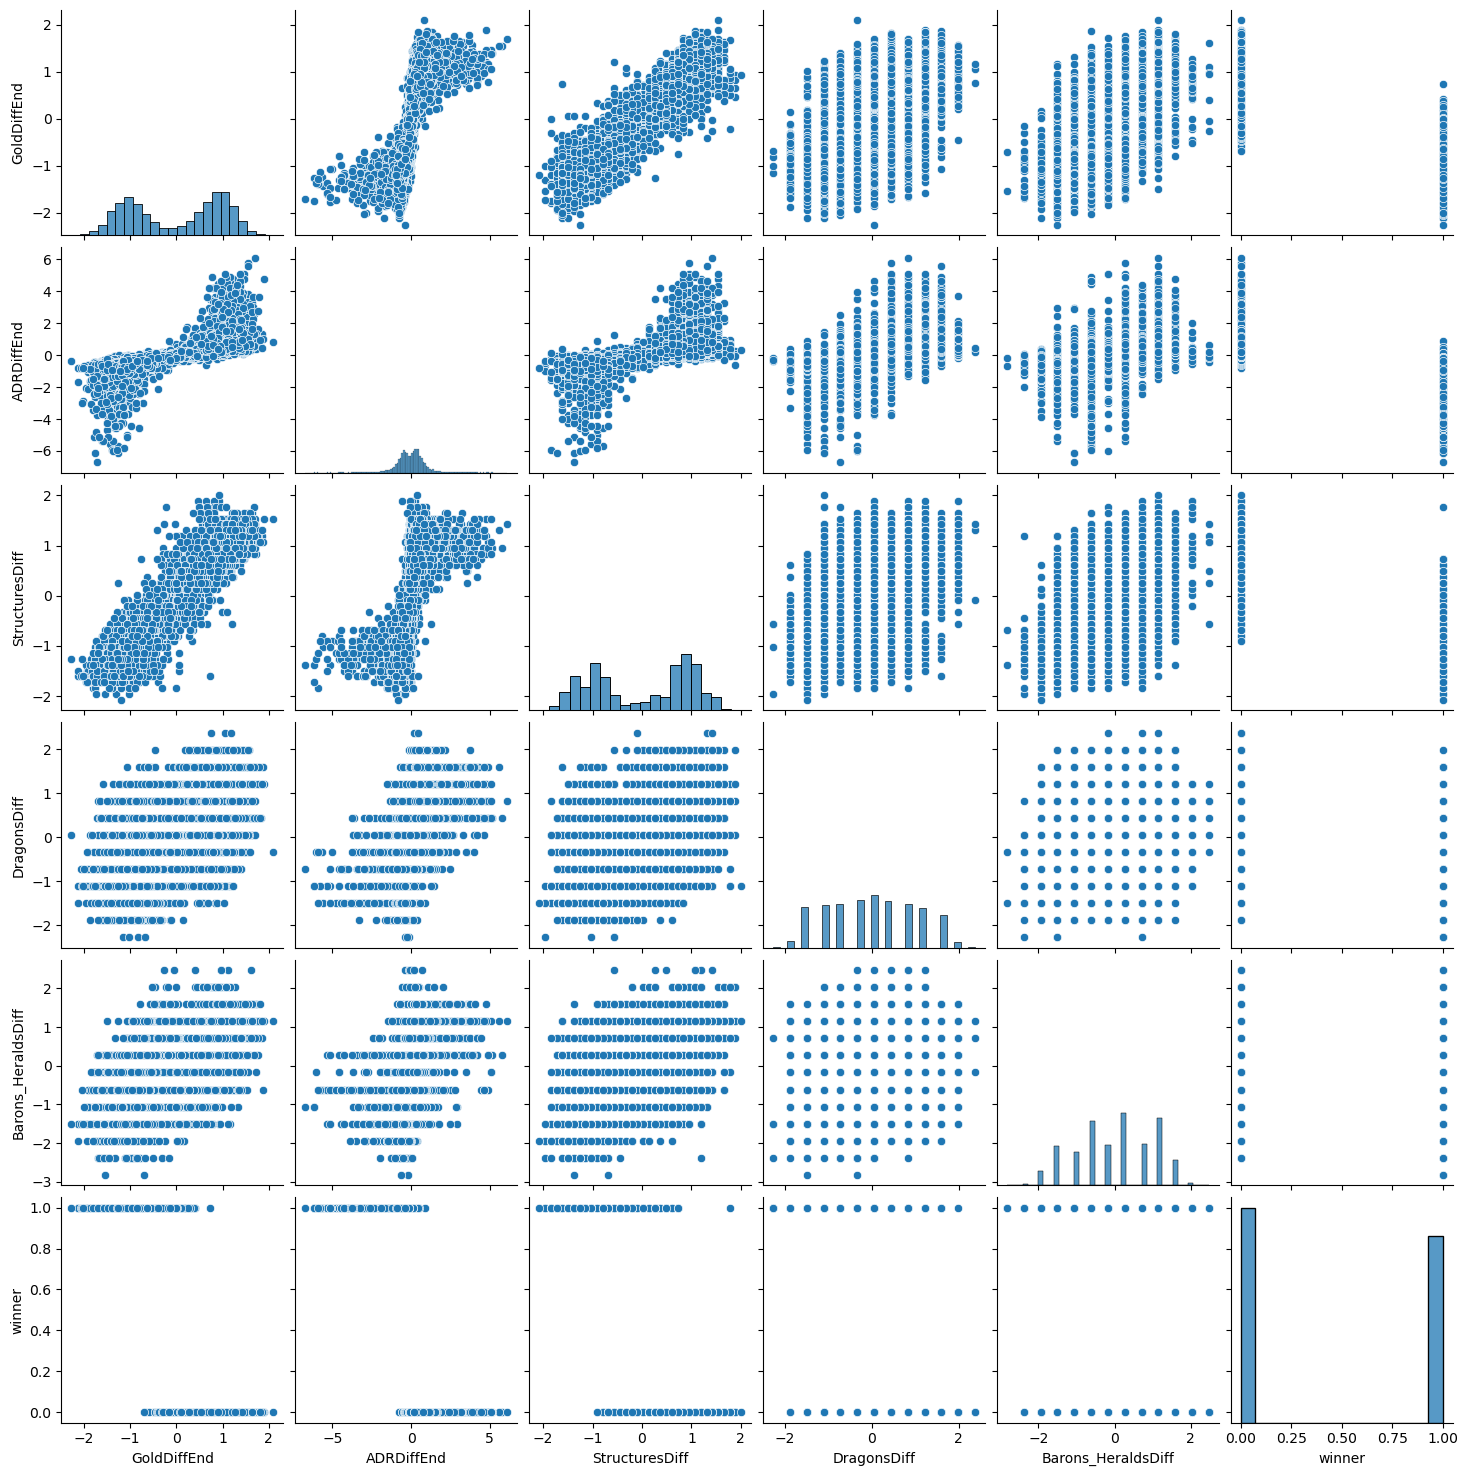

In [121]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


metrics=pd.concat([metrics_rescaled,pd.DataFrame(metrics_df['winner'])], axis=1)
metrics['winner']=metrics['winner'].apply(lambda x: 1 if x == 'red' else 0)



sns.pairplot(metrics)
plt.show()

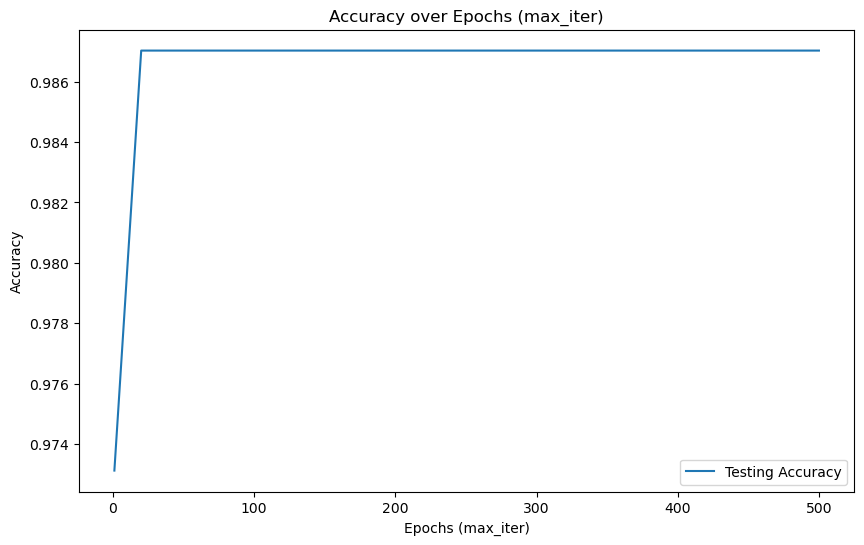

In [122]:
from sklearn.metrics import accuracy_score
accuracies = []
# Specify the range of 'epochs' you want to test
epochs = [1,20,70,90,100,120,140,170,200,240,250,280,300,350,400,450,500]  # Example: 1 to 10

for epoch in epochs:
    # Create and train the logistic regression model
    model = LogisticRegression(max_iter=epoch, n_jobs=-1 , penalty='l2' , solver='lbfgs' ,C=0.01
                               )
    
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    

    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    print()

# Now you can plot the accuracies over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, accuracies, label='Testing Accuracy')
plt.xlabel('Epochs (max_iter)')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs (max_iter)')
plt.legend()
plt.show()

In [123]:
for index, col in enumerate(metrics_rescaled.columns):
    metrics_rescaled[col]*=logreg.coef_[0,index]

# Perform the sum to obtain the total score
metrics_rescaled['gameScore'] = metrics_rescaled.sum(axis=1)

#Assemble our output
metrics_rescaled['esportsPlatformId'] = platformId_ser

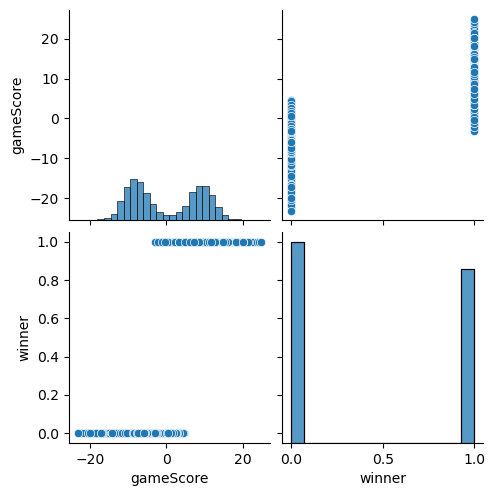

In [124]:
metrics=pd.concat([metrics_rescaled['gameScore'],pd.DataFrame(metrics_df['winner'])], axis=1)

metrics['winner']=metrics['winner'].apply(lambda x: 1 if x == 'red' else 0)



sns.pairplot(metrics)
plt.show()

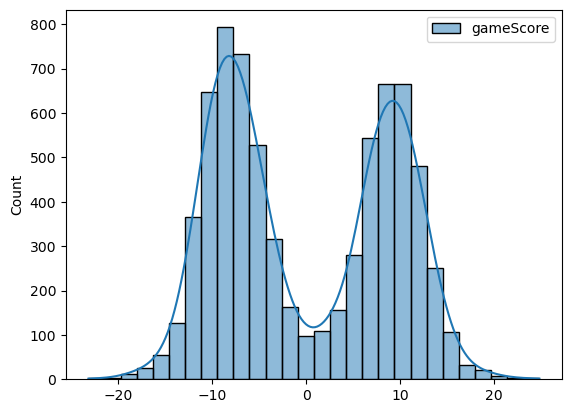

In [126]:
sns.histplot(metrics_rescaled[['gameScore']],kde=True)
plt.show()

In [127]:
metrics_rescaled.to_csv('Games_Scored.csv')

In [128]:
(metrics_rescaled['gameScore']).describe()

count    7.191000e+03
mean     6.916700e-17
std      9.135025e+00
min     -2.318598e+01
25%     -8.241440e+00
50%     -2.677702e+00
75%      8.821323e+00
max      2.483098e+01
Name: gameScore, dtype: float64

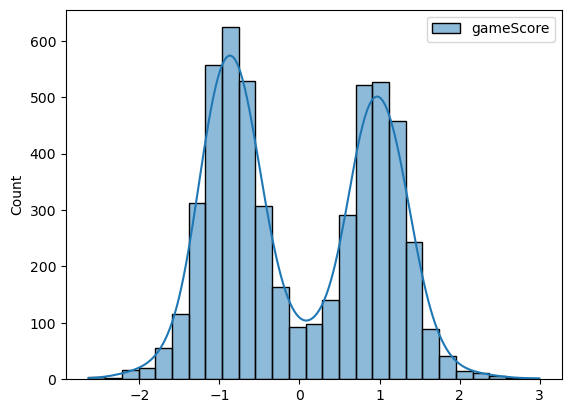

In [96]:
sns.histplot(metrics_rescaled[['gameScore']]/9.33,kde=True)
plt.show()

### Elo rating

In [26]:
with open("esports-data/tournaments.json", "r") as json_file:
       tournaments_data = json.load(json_file)
with open("esports-data/mapping_data.json", "r") as json_file:
       mappings_data = json.load(json_file)
with open("esports-data/teams.json", "r") as json_file:
       teams_data = json.load(json_file)

In [129]:
team_list=[]

for teams in teams_data:
    slug=teams.get('slug')
    acronym=teams.get('acronym')
    team_id=teams.get('team_id')
    name=teams.get('name')
    team_list.append({
  "team_id": team_id,
  "name": name,
  "acronym": acronym,
  "slug": slug
})
team_data=pd.DataFrame(team_list)

In [130]:
team_data

,team_id,name,acronym,slug
0,107582169874155554,God's Plan,GDP,gods-plan
1,105550059790656435,T1 Esports Academy,T1,t1-challengers
2,103535282143744679,Dark Passage Akademi,DP,dark-passage-akademi
3,109637393694097670,Team Heretics,TH,team-heretics-lec
4,101157821387445307,Caps,EU1,caps
...,...,...,...,...
669,105550033967461806,DRX Challengers,DRX,drx-challengers
670,99294153824386385,Golden Guardians,GG,golden-guardians
671,105593278887024877,Inaequalis,INAE,inaequalis
672,105559480124455983,SK Gaming Prime,SKP,sk-gaming-prime


In [39]:
def get_team_id_from_acronym(team_data, acronym):
    # Filtrer les données pour l'acronyme spécifié
    filtered_data = team_data[team_data['acronym'] == acronym]

    # Si un seul identifiant est trouvé, le renvoyer
    if len(filtered_data) == 1:
        return filtered_data['team_id'].iloc[0]

    # Si plusieurs identifiants sont trouvés, créer un dictionnaire avec slug comme clé
    elif len(filtered_data) > 1:
        return dict(zip(filtered_data['slug'], filtered_data['team_id']))

    else:
        return None

In [51]:
get_team_id_from_acronym(team_data=team_data,acronym='T1')['t1-challengers']

'105550059790656435'

In [42]:
def get_team_matches_updated(team_id, mapping_data):
    """Return matches for a given team_id, including the esportsPlatformId and the side (blue or red)"""
    matches = []
    for entry in mapping_data:
        team_mapping = entry.get('teamMapping', {})
        if team_mapping.get('100') == team_id:
            matches.append({
                "esportsPlatformId": entry['platformGameId'],
                "side": "blue"
            })
        elif team_mapping.get('200') == team_id:
            matches.append({
                "esportsPlatformId": entry['platformGameId'],
                "side": "red"
            })
    return matches

In [88]:
def compute_total_game_lp_updated(data, esportsPlatformId, variable_weights):
    """Computes LP for a given game based on various variable weights, with error handling"""

    with pd.option_context('mode.chained_assignment', None): # To avoid warning messages 
        data['version'] = data['gameVersion'].str.split('.').str[0:2].str.join('.')
        data = data.dropna(subset=['version'])
        side_values = data.groupby(
            ['version', 'winner']).size().unstack().fillna(0)
        side_values['side'] = side_values['blue'] - side_values['red']
        data.loc[:, 'side'] = data.loc[:,'version'].map(side_values['side'])


        filtered_data = data[data['esportsPlatformId'] == esportsPlatformId]
        if filtered_data.empty:
            return f" The Game has not beed downloaded yet, try to download it before computing its scores"
        game_data = filtered_data.iloc[0]
        lp_points = {"Blue": 0, "Red": 0}

        for position in ["Top", "Jg", "Mid", "AD", "Bot"]:
            gold_diff_15 = game_data[f"GoldDiff15{position}"]
            gold_diff_end = game_data[f"GoldDiffEnd{position}"]
            lp_points["Blue"] += variable_weights["GoldDiff"] * \
                (gold_diff_15 + gold_diff_end)
            lp_points["Red"] -= variable_weights["GoldDiff"] * \
                (gold_diff_15 + gold_diff_end)



        vision_score_blue = sum(game_data[f"VisionScore{position}Blue"] for position in [
                                "Top", "Jg", "Mid", "AD", "Sup"])
        vision_score_red = sum(game_data[f"VisionScore{position}Red"] for position in [
                            "Top", "Jg", "Mid", "AD", "Sup"])
        lp_points["Blue"] += variable_weights["VisionScore"] * vision_score_blue
        lp_points["Red"] += variable_weights["VisionScore"] * vision_score_red

        for team in ["Blue", "Red"]:
            assists_15 = game_data[f"{team}Assists15"]
            deaths_15 = game_data[f"{team}Deaths15"] if game_data[f"{team}Deaths15"] != 0 else 1
            assists_end = game_data[f"{team}AssistsEnd"]
            deaths_end = game_data[f"{team}DeathsEnd"] if game_data[f"{team}DeathsEnd"] != 0 else 1
            lp_points[team] += variable_weights["KillsDeaths"] * \
                ((assists_15 / deaths_15) + (assists_end / deaths_end))

        objectives = {
            "TowerKillsEnd": game_data["BlueTowerKillsEnd"] - game_data["RedTowerKillsEnd"],
            "InhibKillsEnd": game_data["BlueInhibKillsEnd"] - game_data["RedInhibKillsEnd"],
            "BaronKillsEnd": game_data["BlueBaronKillsEnd"] - game_data["RedBaronKillsEnd"],
            "DragonKillsEnd": game_data["BlueDragonKillsEnd"] - game_data["RedDragonKillsEnd"],
            "RiftHeralds": game_data["NbRiftHeraldsBlue"] - game_data["NbRiftHeraldsRed"]
        }
        for objective, value in objectives.items():
            lp_points["Blue"] += variable_weights["Objectives"] * value
            lp_points["Red"] -= variable_weights["Objectives"] * value

        
        objectives_value=0
        for objective,value in objectives.items():
            objectives_value += variable_weights['Objectives'] * value
        

        GoldDiff_value=0
        for position in ["Top", "Jg", "Mid", "AD", "Bot"]:
            gold_diff_15 = game_data[f"GoldDiff15{position}"]
            gold_diff_end = game_data[f"GoldDiffEnd{position}"]
            GoldDiff_value += variable_weights['GoldDiff'] * (gold_diff_15 + gold_diff_end)



        variable_values={'Red' : {'Objectives': -objectives_value , 'GoldDiff' : -GoldDiff_value}, "Blue" :{'Objectives': objectives_value , 'GoldDiff' : GoldDiff_value}}

    return lp_points

In [89]:
variable_weights = {
    "GoldDiff": 0.1,
    "VisionScore": 0.01,
    "KillsDeaths": 1,
    "Objectives": 0.5
}
compute_total_game_lp_updated(game_dataFrame,'ESPORTSTMNT06:2541842',variable_weights=variable_weights)

' The Game has not beed downloaded yet, try to download before computing its scores'

In [90]:
def generate_team_report_updated(data, mapping_data, team_id):
    """Generates a team report based on provided data files and team ID, with error handling"""

    team_matches = get_team_matches_updated(team_id, mapping_data)
    results = []
    for match in team_matches:
        esportsPlatformId = match['esportsPlatformId']
        lp_points = compute_total_game_lp_updated(data, esportsPlatformId, variable_weights)
        try:
            lp_change = lp_points['Blue'] if match['side'] == 'blue' else lp_points['Red']
            results.append({
            "esportsPlatformId": esportsPlatformId,
            "side": match['side'],
            "lp_change": lp_change
        })
        except TypeError:
            continue
    df_results = pd.DataFrame(results)
    return df_results


In [91]:
game_data=game_dataFrame.copy()
t1_id=get_team_id_from_acronym(team_data=team_data,acronym='T1')['t1-challengers']
results=generate_team_report_updated(game_data,mapping_data=mappings_data,team_id=t1_id)

In [79]:
results

,esportsPlatformId,side,lp_change
0,ESPORTSTMNT03:3088332,red,624.875489
1,ESPORTSTMNT03:3118662,red,-472.585854
2,ESPORTSTMNT03:3119620,red,-786.967049
3,ESPORTSTMNT02:3217610,red,-1036.996876
4,ESPORTSTMNT01:3301957,blue,-723.111974
...,...,...,...
67,ESPORTSTMNT01:3306451,red,1087.382579
68,ESPORTSTMNT01:3308320,red,-2075.775909
69,ESPORTSTMNT03:3089608,red,-955.494390
70,ESPORTSTMNT03:3092934,red,-877.699863


In [61]:
# list_teams=[]
# for entry in mappings_data:
#     teamMapping=entry.get('teamMapping')
#     red_team=teamMapping.get('100')
#     blue_team=teamMapping.get('200')
#     if (red_team in team_data['team_id'].unique()):
#         list_teams.append({'team_id' : red_team , 'acronym' : team_data[team_data['team_id']==red_team]['acronym']})
#     if (blue_team in team_data['team_id'].unique()):
#         list_teams.append({'team_id' : blue_team , 'acronym' : team_data[team_data['team_id']==blue_team]['acronym']})

# teams_available=pd.DataFrame(list_teams)
# teams_available


,team_id,acronym
0,105550033967461806,"669 DRX Name: acronym, dtype: object"
1,105550026570060790,"174 DK Name: acronym, dtype: object"
2,109485335453835911,"157 VKS Name: acronym, dtype: object"
3,105550005698683818,"18 LBR Name: acronym, dtype: object"
4,109696092218588987,"311 NGX Name: acronym, dtype: object"
...,...,...
50234,99322214691747156,"250 SPY Name: acronym, dtype: object"
50235,100205573495116443,"23 GEN Name: acronym, dtype: object"
50236,100205573496804586,"564 HLE Name: acronym, dtype: object"
50237,103877675241047720,"451 LDLC Name: acronym, dtype: object"
